In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 248 kB 8.6 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [ ]:
import os
import gym
import h5py
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from datetime import datetime 
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive



In [ ]:
POWER = 30
channel_no=1
Tag = 'WSEEonlyParam'
GAMMA = 0.6
BATCH_SIZE = 40
LAYERS = [600,500,400]
UEs = 6
APs = 32
dist = '250'
config = 'gamma_'+str(GAMMA)+'_batch_'+str(BATCH_SIZE)+'_layers'+str(LAYERS[0])+'_'+str(LAYERS[1])+'_UEs'+str(UEs)+'_APs'+str(APs)+'_dist'+str(dist)
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'power_'+str(POWER)+'channel_'+str(channel_no)+str(Tag)+'config_'+str(config))
dest = Path(str(path)+'/testlogs')
dest.mkdir(parents=True, exist_ok=True)
dest2 = Path(str(path)+'/models')
# model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)

Mounted at /content/gdrive


In [ ]:


from collections import deque
import random
import gym
from gym import spaces
import h5py
import numpy as np

# dist_filename = 'testNrx/dist_K6_AP10_2k_20x20.h5'
# channel_K6_AP10_2k_20x20


class wirelessCF(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, pu, nrx, gainspath='/channels/channel_K6_AP32_2k_250x250.h5', channel_setup=channel_no, seed=0, eval = None):
    np.random.seed(seed)
    random.seed(seed)
    
    super(wirelessCF, self).__init__()
    

    # cf parameters
    self.channelGains = h5py.File(base_dir+str(gainspath), 'r')
    self.pu = np.power(10, pu/10 - 3)
    self.B = 20000000
    self.N0 = 1
    self.T_c = 0.001
    self.Ptcm = 0.2
    self.Ptcl = 0.2
    self.Pom = 0.825
    self.pp = 0.2
    self.K = UEs
    self.tauc = 200
    self.eff = 0.4 #amplifier efficiency
    self.M = APs

    self.Pft = 10
    self.C_fh = 100000000
    self.nu = 2
    self.a = 0.88115
    self.b = 0.88115
    self.taup = self.K
    self.tauf = 1 - (self.taup/self.tauc)
    self.Nrx = nrx
    self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
    self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
    self.theta_max = 1
    self.alpha = deque(maxlen=1)
    self.beta = deque(maxlen=1)
    self.ch_gain = deque(maxlen=1)
    self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
    self.pi = deque(maxlen=1)
    self.reward_timediff = deque([0,0],maxlen=2)
    self.initialize_p()
    self.channel_setup = channel_setup
    self.initialize_matrix(channel_setup)
    self.max_episode_step = 100

    # define action and obervation space:
    self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                        shape=(self.K,), dtype=np.float32)
    MIN_ACTION = 10e-7
    self.action_space = spaces.Box(low=MIN_ACTION, high=1,
                                  shape=(self.K,), dtype=np.float32)    

    self.eval = eval

    # history parameters
    self.WSEE_history = []
    self.sumSE_history = []
    self.FPA_WSEE_history = []
    self.FPA_sumSE_history = []
    self.score_history = []
    self.step_WSEE = []
    self.step_sumSE = []
    self.step_score = []

    self.global_step = 0

    # eval history
    # self.eval_history = {}
    # self.eval_history['WSEE'] = []
    # self.eval_history['sumSE'] = []
    # self.eval_history['FPA_WSEE'] = []
    # self.eval_history['FPA_sumSE'] = []
    # self.eval_history['score'] = []

  def initialize_matrix(self, episode):
        BETA = self.channelGains['channelGain'][episode].transpose()
        self.largeScaleFading = BETA
        # BETA = np.random.uniform(0,10,size=(1,self.K,self.M))
        # h5f = h5py.File(str(dest)+'/rand_BETA.h5', 'w')
        # h5f.create_dataset('channelGain', data=BETA)
        # h5f.close()
        # BETA = BETA[0].transpose()
        print(BETA)
        gamma_num = np.zeros((self.M,self.K))
        gamma_den = np.zeros((self.M,self.K))

        Gamma = np.zeros((self.M,self.K))
        for m in range(self.M):
            for k in range(self.K):
                gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
        self.ch_gain.append(Gamma)
        alpha1 = np.zeros((self.K,))
        for k in range(self.K):
            #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
            alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
        self.alpha.append(alpha1)
        beta1 = np.zeros((self.K,self.K))
        for k in range(self.K):
            for q in range(self.K):
                beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
        self.beta.append(beta1)
        return 
  
  def initialize_p(self):
      self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
      return
    
  def cal_alpha_p(self, i, t):
      val = self.alpha[t][i]*self.pi[t][i]
      return val
  
  def cal_beta_p(self, i, j, t):
      val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
      return val
  
  def sum_beta_p(self, i, t):
      val = 0
      for j in range(self.K):
          val += self.cal_beta_p(i,j,t)  
      return val 

  def cal_SINR(self,i,t):
      val = self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + \
                                              (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + \
                                              self.b/(self.a*self.a)*self.sum_beta_p(i, t))
      return val

  def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_SINR(i,t)))
        return val
      
  def cal_equal_p_Ri(self,i, t):
      p = [self.theta_max for x in range(self.K)]
      temp = self.pi.copy()
      self.pi[t] = p
      val = self.cal_Ri(i,t)
      self.pi = temp
      return val

  def cal_EEi(self,i,t):
      val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
      return val

  def cal_total_WSEE(self,t):
      val = 0
      for x in range(self.K):
          val += self.wi[x]*self.cal_EEi(x,t)
      return val
  
  def cal_equal_p_WSEE(self, t):
      p = [self.theta_max for x in range(self.K)]
      temp = self.pi.copy()
      self.pi[t] = p
      val = self.cal_total_WSEE(t)
      self.pi = temp
      return val

  def cal_SE_vec(self,t):
      SEs = []
      for u in range(self.K):
        SE_u = self.tauf*self.cal_Ri(u,t)
        SEs.append(SE_u)
      return SEs

  def cal_sum_SE(self,t):
      SEs = self.cal_SE_vec(t)
      sum_SE = sum([se for se in SEs])
      return sum_SE

  def cal_fpa_SE_vec(self,t):
      SEs = []
      for u in range(self.K):
        SE_u = self.tauf*self.cal_equal_p_Ri(u,t)
        SEs.append(SE_u)
      return SEs

  def cal_sum_fpa_SE(self,t):
      SEs = self.cal_fpa_SE_vec(t)
      sum_SE = sum([se for se in SEs])
      return sum_SE

  def cal_reward(self,t):
      """
      SE optimization
      """
      # ri = self.cal_sum_SE(t) 
      """
      WSEE optimization
      """
      r = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t)
      # ri = self.cal_total_WSEE(t)
      # self.reward_timediff.append(ri)
      # r = self.reward_timediff[1]-self.reward_timediff[0]
      return r

  def cal_state(self):
      state = []
      for t in range(1): #for current timestep only
          for k in range(self.K):
            state.append(self.cal_SINR(k,t)) #M
          
      # state = np.reshape(state, [1, self.observation_space.shape[0]])
      normalized_states = state/np.max(state)
      # return normalized_states
      return -np.log10(state)

  def initialize_state(self):
      state = self.cal_state()
      return state

  def reset(self):
      # self.initialize_matrix(self.channel_setup)
      self.initialize_p()
      self.episode_step = 0
      state = self.initialize_state()
      return state

          
  def step(self, actions):
      self.episode_step += 1
      self.global_step += 1
      # actions = actions[0] #theres an extra dim
      self.pi.append(actions)
      next_state = self.cal_state()
      reward = self.cal_reward(0)
      # next_state = np.reshape(next_state, [1, self.observation_space.shape[0]])
      done = False
      
      self.step_WSEE.append(self.cal_total_WSEE(0))
      self.step_sumSE.append(self.cal_sum_SE(0))
      self.step_score.append(reward)
      if self.episode_step >= self.max_episode_step:
          
          self.WSEE_history.append(np.mean(self.step_WSEE))
          self.sumSE_history.append(np.mean(self.step_sumSE))
          self.score_history.append(np.mean(self.step_score))
          self.FPA_WSEE_history.append(self.cal_equal_p_WSEE(0))
          self.FPA_sumSE_history.append(self.cal_sum_fpa_SE(0))


          self.step_WSEE = []
          self.step_sumSE = []
          self.step_score = []

          mode = "Training"
          if self.eval:
            mode = "Evaluation"
          print(f'  {str(mode)}: Global Step: {self.global_step} || avg_score: {self.score_history[-1]} || WSEE: {self.WSEE_history[-1]} || FPA_WSEE: {self.cal_equal_p_WSEE(0)} || sumSE: {self.sumSE_history[-1]} || FPA_sumSE: {self.cal_sum_fpa_SE(0)}')

          done = True
          
      info = {
          'WSEE': self.cal_total_WSEE(0),
          'FPA_WSEE': self.cal_equal_p_WSEE(0),
          'sumSE': self.cal_sum_SE(0),
          'FPA_sumSE': self.cal_sum_fpa_SE(0)
      }
      return next_state, reward, done, info

  
  def render(self, mode='human'):
    NotImplementedError
  def close (self):
    NotImplementedError


In [ ]:
# from stable_baselines.common.env_checker import check_env

In [ ]:
# env = wirelessCF(pu=30,nrx=2,seed=0)
# # If the environment don't follow the interface, an error will be thrown
# check_env(env, warn=True)

In [ ]:
import gym
import numpy as np

from stable_baselines.ddpg.policies import MlpPolicy, LnMlpPolicy, FeedForwardPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines import DDPG

# POWER = 50
# channel_no=1
NUM_EPISODES = 2500
env = wirelessCF(pu=POWER, nrx=2, channel_setup=channel_no, seed=0)

eval_env = wirelessCF(pu=POWER, nrx=2, channel_setup=channel_no, seed=0, eval=True)

policy_kwargs = dict(layers=LAYERS)
# policy_kwargs = None

# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1, adoption_coefficient=1.01)
# param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.3) * np.ones(n_actions))

SEED=3
model = DDPG(MlpPolicy, env, policy_kwargs = policy_kwargs, eval_env = eval_env, gamma=GAMMA, verbose=2, param_noise=param_noise, action_noise=action_noise, batch_size=BATCH_SIZE, 
             buffer_size=1000000, tau = 0.00001, actor_lr=1e-7, critic_lr=1e-6, observation_range=(-np.inf,np.inf), critic_l2_reg=0.01, seed=SEED)
# print(model.policy_tf.layers)
model.learn(total_timesteps=NUM_EPISODES*100)
model.save("ddpg_wireless")



Streaming output truncated to the last 5000 lines.
  Evaluation: Global Step: 31500 || avg_score: 0.026263638296853953 || WSEE: 0.2314300055314597 || FPA_WSEE: 0.2051663672346057 || sumSE: 14.531471531856605 || FPA_sumSE: 14.423031483498992
  Training: Global Step: 31600 || avg_score: 0.028682963383575646 || WSEE: 0.23384933061818136 || FPA_WSEE: 0.2051663672346057 || sumSE: 14.630926304663753 || FPA_sumSE: 14.423031483498992
  Evaluation: Global Step: 31600 || avg_score: 0.026277730315050193 || WSEE: 0.23144409754965595 || FPA_WSEE: 0.2051663672346057 || sumSE: 14.53235828195995 || FPA_sumSE: 14.423031483498992
  Training: Global Step: 31700 || avg_score: 0.031440386505836256 || WSEE: 0.23660675374044196 || FPA_WSEE: 0.2051663672346057 || sumSE: 14.782185282460755 || FPA_sumSE: 14.423031483498992
  Evaluation: Global Step: 31700 || avg_score: 0.026289451382378783 || WSEE: 0.23145581861698453 || FPA_WSEE: 0.2051663672346057 || sumSE: 14.533114160321098 || FPA_sumSE: 14.423031483498992


In [ ]:
import pandas as pd
########################## Random Scheme ##################################
temp = env.pi
random_WSEE = []
# random_SEs = []
random_sum_SE = []
# random_constraint_value = []
for i in range(NUM_EPISODES):
  action = np.random.uniform(0,1,(env.action_space.shape[0]))
  env.pi.append(action)
  next_state = env.cal_state()
  reward = env.cal_reward(0)
  # next_state = np.reshape(next_state, [1, self.observation_space.shape[0]])
  done = False
  # random_SEs.append(env.SEs.tolist())
  random_sum_SE.append(env.cal_sum_SE(0))
  random_WSEE.append(env.cal_total_WSEE(0))
  # print(random_sum_SE, random_WSEE)
  # print()
  
env.pi = temp
powerdbm = POWER

rand_df_wsee = pd.DataFrame(data=random_WSEE, columns=['WSEE'])
rand_df_wsee.to_csv(str(dest)+'/'+str(Tag)+'rand_WSEE'+str(powerdbm)+'.csv')

# rand_data_se = pd.DataFrame(data=random_SEs,columns=['SE'+str(i) for i in range(1,env.K+1)])
# rand_data_se.to_csv(str(dest)+'/'+str(Tag)+'rand_SEs'+str(powerdbm)+'.csv')

rand_df_sumSE = pd.DataFrame(data=random_sum_SE, columns=['sum_SE'])
rand_df_sumSE.to_csv(str(dest)+'/'+str(Tag)+'rand_sum_SE'+str(powerdbm)+'.csv')

###########################################################################

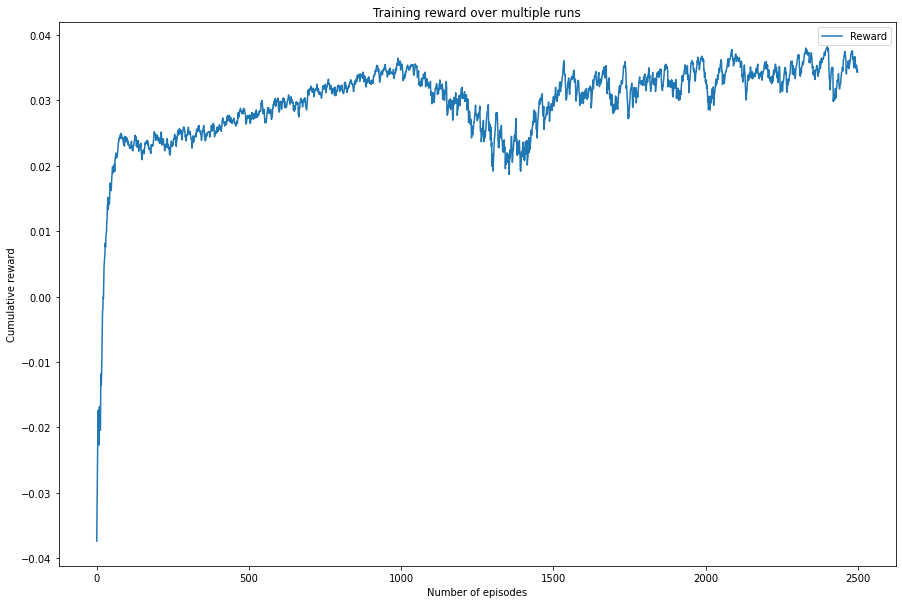

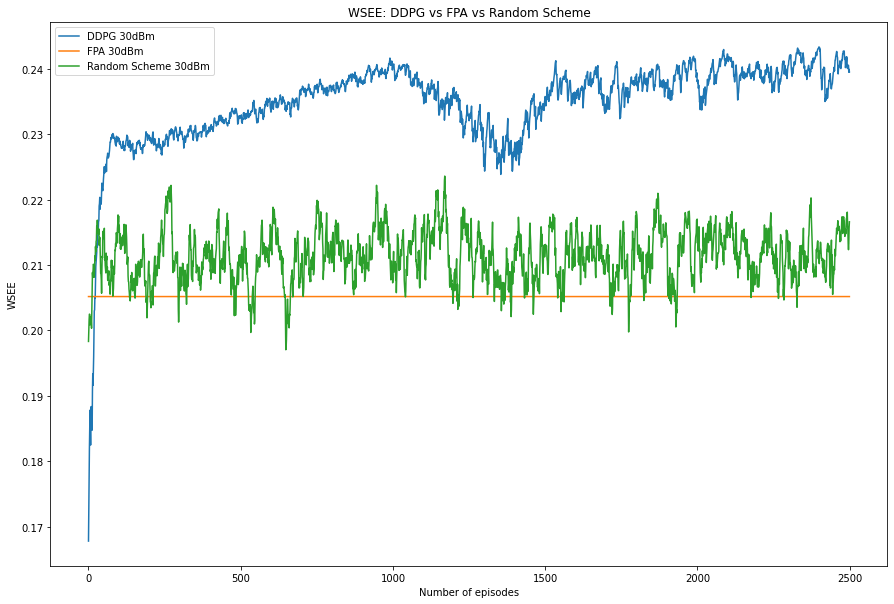

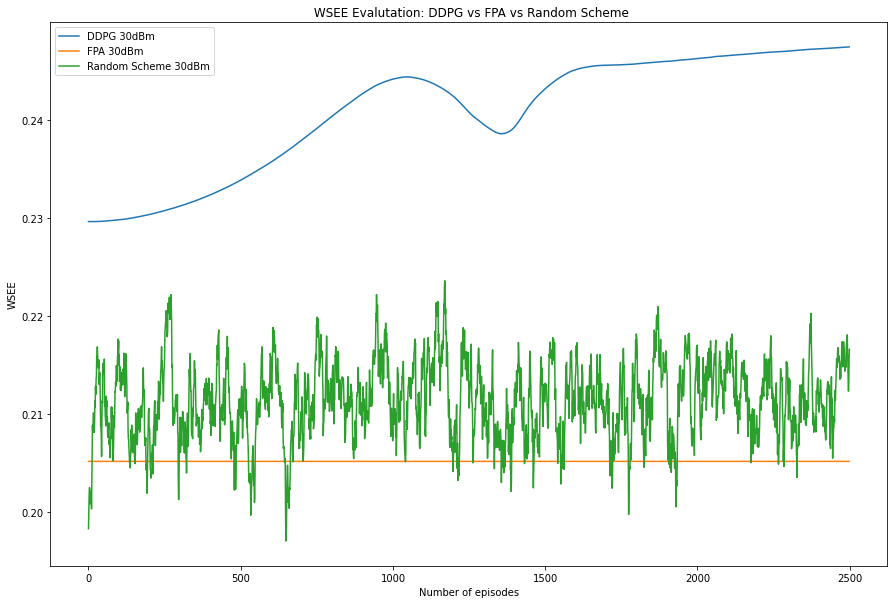

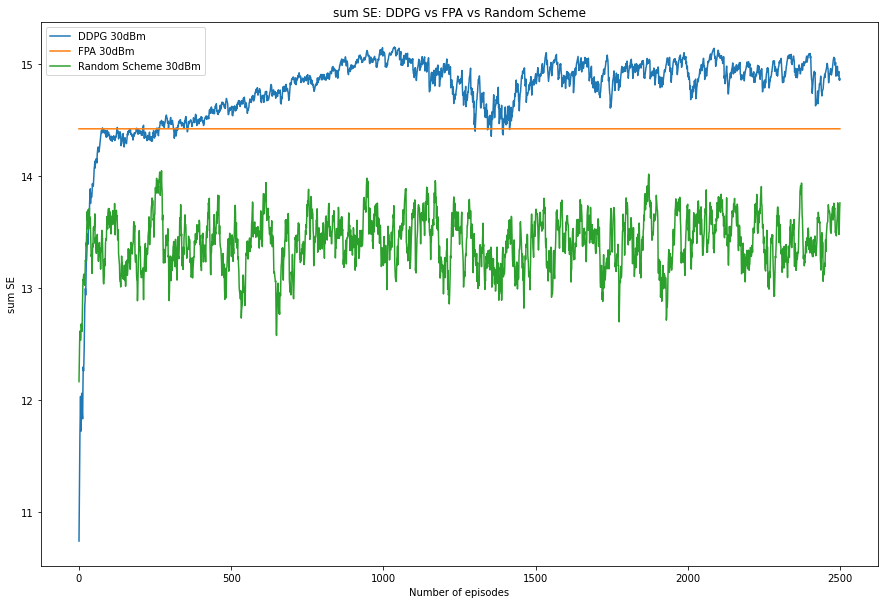

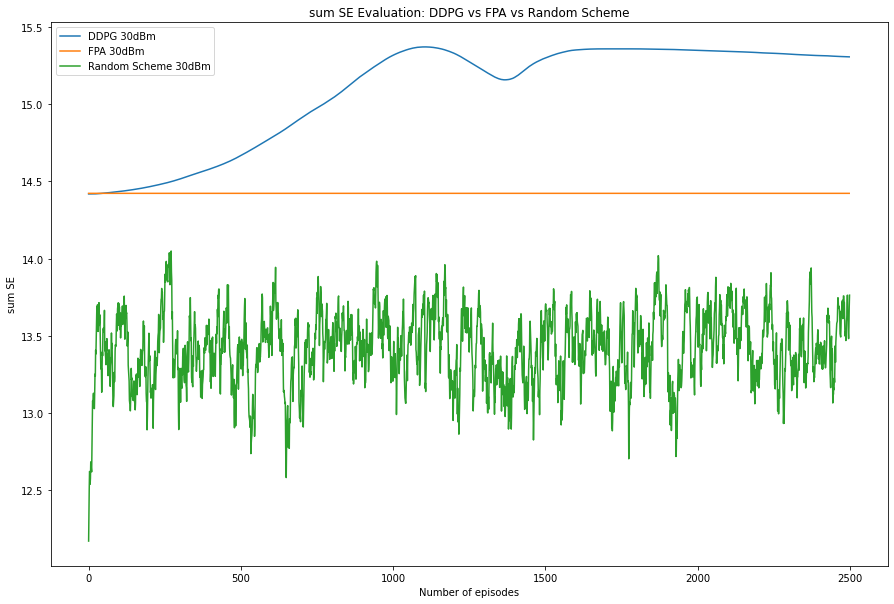

In [ ]:
episode = [i for i in range(NUM_EPISODES)]
eval_episode = [i for i in range(len(eval_env.WSEE_history))]
powerdbm = POWER

df_wsee = pd.DataFrame(data=env.WSEE_history, columns=['WSEE'])
df_wsee.to_csv(str(dest)+'/'+str(Tag)+'WSEE'+str(powerdbm)+'.csv')

df_eval_wsee = pd.DataFrame(data=eval_env.WSEE_history, columns=['WSEE'])
df_eval_wsee.to_csv(str(dest)+'/'+str(Tag)+'eval_WSEE'+str(powerdbm)+'.csv')

df_fpawsee = pd.DataFrame(data=env.FPA_WSEE_history, columns=['WSEE'])
df_fpawsee.to_csv(str(dest)+'/'+str(Tag)+'FPA_WSEE'+str(powerdbm)+'.csv')

df_reward = pd.DataFrame(data=env.score_history, columns=['reward'])
df_reward.to_csv(str(dest)+'/'+str(Tag)+'reward'+str(powerdbm)+'.csv')

df_eval_reward = pd.DataFrame(data=eval_env.score_history, columns=['reward'])
df_eval_reward.to_csv(str(dest)+'/'+str(Tag)+'eval_reward'+str(powerdbm)+'.csv')

df_sumSE = pd.DataFrame(data=env.sumSE_history, columns=['sum_SE'])
df_sumSE.to_csv(str(dest)+'/'+str(Tag)+'sum_SE'+str(powerdbm)+'.csv')

df_eval_sumSE = pd.DataFrame(data=eval_env.sumSE_history, columns=['sum_SE'])
df_eval_sumSE.to_csv(str(dest)+'/'+str(Tag)+'eval_sum_SE'+str(powerdbm)+'.csv')

df_fpasumSE = pd.DataFrame(data=env.FPA_sumSE_history, columns=['sum_SE'])
df_fpasumSE.to_csv(str(dest)+'/'+str(Tag)+'FPA_sum_SE'+str(powerdbm)+'.csv')


def numpy_ewma_vectorized_v2(data, window):

  alpha = 2 /(window + 1.0)
  alpha_rev = 1-alpha
  n = data.shape[0]

  pows = alpha_rev**(np.arange(n+1))

  scale_arr = 1/pows[:-1]
  offset = data[0]*pows[1:]
  pw0 = alpha*alpha_rev**(n-1)

  mult = data*pw0*scale_arr
  cumsums = mult.cumsum()
  out = offset + cumsums*scale_arr[::-1]
  return out

smooth_window = 20

plt.figure(figsize=(15,10))
reward = numpy_ewma_vectorized_v2(np.array(env.score_history),smooth_window)
episode = np.array(episode)

plt.plot(episode, reward,'-' ,label='Reward')
plt.title('Training reward over multiple runs')
plt.xlabel('Number of episodes')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig(dest/r'reward.jpg', dpi=300)
plt.show()



plt.figure(figsize=(15,10))
out_WSEE = numpy_ewma_vectorized_v2(np.array(env.WSEE_history),smooth_window)
FPA_WSEE = numpy_ewma_vectorized_v2(np.array(env.FPA_WSEE_history),smooth_window)
rand_WSEE = numpy_ewma_vectorized_v2(np.array(random_WSEE),smooth_window)

plt.plot(episode, out_WSEE,'-' ,label='DDPG '+str(POWER)+'dBm')
plt.plot(episode, FPA_WSEE,'-' ,label='FPA '+str(POWER)+'dBm')
plt.plot(episode, rand_WSEE,'-' ,label='Random Scheme '+str(POWER)+'dBm')
plt.title('WSEE: DDPG vs FPA vs Random Scheme')
plt.xlabel('Number of episodes')
plt.ylabel('WSEE')
plt.legend()
plt.savefig(dest/r'WSEE.jpg', dpi=300)
plt.show()

plt.figure(figsize=(15,10))
out_eval_WSEE = numpy_ewma_vectorized_v2(np.array(eval_env.WSEE_history),smooth_window)
FPA_eval_WSEE = numpy_ewma_vectorized_v2(np.array(eval_env.FPA_WSEE_history),smooth_window)
rand_WSEE = numpy_ewma_vectorized_v2(np.array(random_WSEE),smooth_window)

plt.plot(eval_episode, out_eval_WSEE,'-' ,label='DDPG '+str(POWER)+'dBm')
plt.plot(eval_episode, FPA_eval_WSEE,'-' ,label='FPA '+str(POWER)+'dBm')
plt.plot(episode, rand_WSEE,'-' ,label='Random Scheme '+str(POWER)+'dBm')
plt.title(' WSEE Evalutation: DDPG vs FPA vs Random Scheme')
plt.xlabel('Number of episodes')
plt.ylabel('WSEE')
plt.legend()
plt.savefig(dest/r'eval_WSEE.jpg', dpi=300)
plt.show()


plt.figure(figsize=(15,10))
out_sum_SE = numpy_ewma_vectorized_v2(np.array(env.sumSE_history),smooth_window)
FPA_sum_SE = numpy_ewma_vectorized_v2(np.array(env.FPA_sumSE_history),smooth_window)
rand_sum_SE = numpy_ewma_vectorized_v2(np.array(random_sum_SE),smooth_window)

plt.plot(episode, out_sum_SE,'-' ,label='DDPG '+str(POWER)+'dBm')
plt.plot(episode, FPA_sum_SE,'-' ,label='FPA '+str(POWER)+'dBm')
plt.plot(episode, rand_sum_SE,'-' ,label='Random Scheme '+str(POWER)+'dBm')
plt.title('sum SE: DDPG vs FPA vs Random Scheme')
plt.xlabel('Number of episodes')
plt.ylabel('sum SE')
plt.legend()
plt.savefig(dest/r'sum_SE.jpg', dpi=300)
plt.show()

plt.figure(figsize=(15,10))
out_eval_sum_SE = numpy_ewma_vectorized_v2(np.array(eval_env.sumSE_history),smooth_window)
FPA_eval_sum_SE = numpy_ewma_vectorized_v2(np.array(eval_env.FPA_sumSE_history),smooth_window)
rand_sum_SE = numpy_ewma_vectorized_v2(np.array(random_sum_SE),smooth_window)

plt.plot(eval_episode, out_eval_sum_SE,'-' ,label='DDPG '+str(POWER)+'dBm')
plt.plot(eval_episode, FPA_eval_sum_SE,'-' ,label='FPA '+str(POWER)+'dBm')
plt.plot(episode, rand_sum_SE,'-' ,label='Random Scheme '+str(POWER)+'dBm')
plt.title('sum SE Evaluation: DDPG vs FPA vs Random Scheme')
plt.xlabel('Number of episodes')
plt.ylabel('sum SE')
plt.legend()
plt.savefig(dest/r'eval_sum_SE.jpg', dpi=300)
plt.show()
